In [1]:
import numpy as np
import astropy.io.fits as pf
import piff
import matplotlib.pyplot as plt
import galsim
import logging
import pandas
import os
import ngmix
import functions as f
%matplotlib inline

In [2]:
# Don't skip columns in describe output  (default is 20, which is a bit too small)
pandas.options.display.max_columns = 200

In [10]:
ID = '00241238'
chip = '29'
indir = './data/y1_test/'
image = 'DECam_'+str(ID)+'_'+str(chip)+'.fits.fz'
cat = 'DECam_'+str(ID)+'_'+str(chip)+'_cat.fits'
bkg = 'DECam_'+str(ID)+'_'+str(chip)+'_bkg.fits.fz'
findstar = 'DECam_'+str(ID)+'_'+str(chip)+'_findstars.fits'
psfcat = 'DECam_'+str(ID)+'_'+str(chip)+'_psfcat.psf'
psfcat_used = 'DECam_'+str(ID)+'_'+str(chip)+'_psfcat.used.fits'
psfcat_xml = 'DECam_'+str(ID)+'_'+str(chip)+'_psfcat.xml'
psfcat_cut = 'DECam_'+str(ID)+'_'+str(chip)+'_psfcat_tb_maxmag_17.0_magcut_3.0_findstars.fits'

piffdir = '../../../../Users/rebeccachen/Piff/examples/output/'
piff_file = 'DECam_'+str(ID)+'_'+str(chip)+'.piff'

In [11]:
logger = logging.getLogger('run_piff')

In [12]:
BAD_MEASUREMENT = 2
MAX_CENTROID_SHIFT = 1.0
CENTROID_SHIFT = 4

In [13]:
def hsm(im, wt, logger):
    #print('im stats: ',im.array.min(),im.array.max(),im.array.mean(),np.median(im.array))
    #print('wt = ',wt)
    #if wt:
        #print('im stats: ',wt.array.min(),wt.array.max(),wt.array.mean(),np.median(wt.array))
    flag = 0
    try:
        shape_data = im.FindAdaptiveMom(weight=wt, strict=False)
        #print('shape_data = ',shape_data)
    except Exception as e:
        logger.info(e)
        logger.info(' *** Bad measurement (caught exception).  Mask this one.')
        flag |= BAD_MEASUREMENT

    if shape_data.moments_status != 0:
        logger.info('status = %s',shape_data.moments_status)
        logger.info(' *** Bad measurement (hsm status).  Mask this one.')
        flag |= BAD_MEASUREMENT

    if galsim.__version__ >= '1.5.1':
        dx = shape_data.moments_centroid.x - im.true_center.x
        dy = shape_data.moments_centroid.y - im.true_center.y
    else:
        dx = shape_data.moments_centroid.x - im.trueCenter().x
        dy = shape_data.moments_centroid.y - im.trueCenter().y
    #print('dx, dy = ',dx,dy)
    if dx**2 + dy**2 > MAX_CENTROID_SHIFT**2:
        logger.info(' *** Centroid shifted by %f,%f in hsm.  Mask this one.',dx,dy)
        flag |= CENTROID_SHIFT

    flux = shape_data.moments_amp
    #print('flux = ',flux)

    # Account for the image wcs
    if im.wcs.isPixelScale():
        g1 = shape_data.observed_shape.g1
        g2 = shape_data.observed_shape.g2
        T = 2 * shape_data.moments_sigma**2 * im.scale**2
        #print('simple shape = ',g1,g2,T)
    else:
        e1 = shape_data.observed_shape.e1
        e2 = shape_data.observed_shape.e2
        s = shape_data.moments_sigma
        #print('simple shape = ',e1,e2,s)

        if galsim.__version__ >= '1.5.1':
            jac = im.wcs.jacobian(im.true_center)
        else:
            jac = im.wcs.jacobian(im.trueCenter())
        M = np.matrix( [[ 1 + e1, e2 ], [ e2, 1 - e1 ]] ) * s*s
        J = jac.getMatrix()
        M = J * M * J.T

        e1 = (M[0,0] - M[1,1]) / (M[0,0] + M[1,1])
        e2 = (2.*M[0,1]) / (M[0,0] + M[1,1])
        T = M[0,0] + M[1,1]

        shear = galsim.Shear(e1=e1, e2=e2)
        g1 = shear.g1
        g2 = shear.g2
        #print('distorted shape = ',g1,g2,T)

    return dx, dy, g1, g2, T, flux, flag

In [14]:
def make_ngmix_prior(T, pixel_scale):
    from ngmix import priors, joint_prior

    # centroid is 1 pixel gaussian in each direction
    cen_prior=priors.CenPrior(0.0, 0.0, pixel_scale, pixel_scale)

    # g is Bernstein & Armstrong prior with sigma = 0.1
    gprior=priors.GPriorBA(0.1)

    # T is log normal with width 0.2
    Tprior=priors.LogNormal(T, 0.2)

    # flux is the only uninformative prior
    Fprior=priors.FlatPrior(-10.0, 1.e10)

    prior=joint_prior.PriorSimpleSep(cen_prior, gprior, Tprior, Fprior)
    
    return prior

In [15]:
def ngmix_fit(im, wt, fwhm, x, y, logger):
    flag = 0
    dx, dy, g1, g2, flux = 0., 0., 0., 0., 0.
    T_guess = (fwhm / 2.35482)**2 * 2.
    T = T_guess
    try:
        if galsim.__version__ >= '1.5.1':
            wcs = im.wcs.local(im.center)
        else:
            wcs = im.wcs.local(im.center())
#         print('set wcs')
#         print(T, wcs.minLinearScale())
        prior = make_ngmix_prior(T, wcs.minLinearScale())
#         print('made prior')
        if galsim.__version__ >= '1.5.1':
            cen = im.true_center - im.origin
        else:
            cen = im.trueCenter() - im.origin()
        jac = ngmix.Jacobian(wcs=wcs, x=cen.x + x - int(x+0.5), y=cen.y + y - int(y+0.5))
#         jac = ngmix.DiagonalJacobian(scale=(0.27/60/60), row=x, col=y)
#         print(jac.det)
#         print('made jac')
        if wt is None:
            obs = ngmix.Observation(image=im.array, jacobian=jac)
        else:
            obs = ngmix.Observation(image=im.array, weight=wt.array, jacobian=jac)

        lm_pars = {'maxfev':4000}
        runner=ngmix.bootstrap.PSFRunner(obs, 'gauss', T, lm_pars, prior=prior)
        runner.go(ntry=3)
#         print('go runner')
        
        ngmix_flag = runner.fitter.get_result()['flags']
        gmix = runner.fitter.get_gmix()
    except Exception as e:
        logger.info(e)
        logger.info(' *** Bad measurement (caught exception).  Mask this one.')
        flag |= BAD_MEASUREMENT
#         print('hit exception')
        return dx,dy,g1,g2,T,flux,flag

    if ngmix_flag != 0:
        logger.info(' *** Bad measurement (ngmix flag = %d).  Mask this one.',ngmix_flag)
        flag |= BAD_MEASUREMENT

    if abs(g1) > 0.5 or abs(g2) > 0.5:
        logger.info(' *** Bad shape measurement (%f,%f).  Mask this one.',g1,g2)
        flag |= BAD_MEASUREMENT

    dx, dy = gmix.get_cen()
    if dx**2 + dy**2 > MAX_CENTROID_SHIFT**2:
        logger.info(' *** Centroid shifted by %f,%f in ngmix.  Mask this one.',dx,dy)
        flag |= CENTROID_SHIFT

    g1, g2, T = gmix.get_g1g2T()
    flux = gmix.get_flux() / wcs.pixelArea()  # flux is in ADU.  Should ~ match sum of pixels
    #logger.info('ngmix: %s %s %s %s %s %s %s',dx,dy,g1,g2,T,flux,flag)
    return dx, dy, g1, g2, T, flux, flag

In [16]:
x_cat = pf.open(indir+psfcat_cut)[2].data['X_IMAGE']
y_cat = pf.open(indir+psfcat_cut)[2].data['Y_IMAGE']
print(type(x_cat))

<class 'numpy.ndarray'>


In [17]:
#open actual image
stars = pf.open(indir+image) #as fits size:(2048, 4096)
stars_galsim = galsim.fits.read(indir+image) #as galsim image
# im = stars[1].data

#read in PSF model
psf = piff.read(piffdir+piff_file)

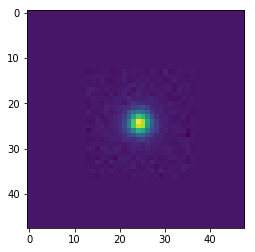

In [18]:
#plot psf at one spot
test = psf.draw(x_cat[0],y_cat[0])
# test = psf.draw(1, 1, test)
test.write('test.fits')
galsim.fits.write(test, 'test_galsim.fits', piffdir)
test = pf.open('test.fits')
test_galsim = galsim.fits.read('test_galsim.fits', piffdir)
#plt.imshow(test[0].data)

plt.imshow(test_galsim.array)

plt.show()

In [19]:
# magzp = 0 #TODO: read in properly from data
# df = f.read_findstars(findstar, cat, magzp, logger)
# re = get_fwhm(df)

In [20]:
#testing ngmix_fit
fwhm = 0.8 #to do: calculate median fwhm
x1 = 651.232
y1 = 120.327
# x1 = -607.4180109459476
# y1 = 392.1524909334519

results = ngmix_fit(test_galsim, None, fwhm, x1, y1, logger)
print(results)
#dx, dy, g1, g2, T, flux, flag

(-0.0003880980493792303, -0.0003853199428428094, 2.558899515533651e-06, 4.795607150729876e-06, 0.0998202723793464, 0.29781203313125143, 0)


In [21]:
#testing hsm
dx, dy, g1, g2, T, flux, flag = hsm(test_galsim, None, logger)
print(dx, dy, g1, g2, T, flux, flag)

0.7497277759187 0.8592142639342057 0.006096748164112276 0.009908098696263022 0.43715717466791215 0.8456628918647766 4


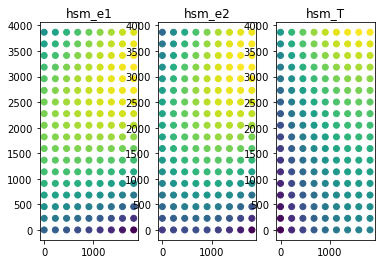

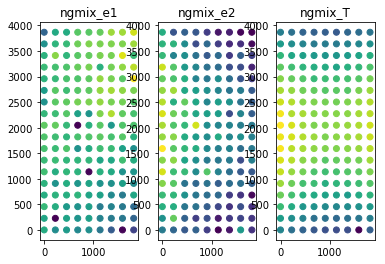

In [22]:
#plot psf shape/size over grid
grid_x = []
grid_y = []
grid_e1 = []
grid_e2 = []
grid_sizes = []
grid_e1_2 = []
grid_e2_2 = []
grid_sizes_2 = []
for i in range(9):
    for j in range(18):
        temp = psf.draw(int(i*(2048/9)), int(j*(4096/18)))
        grid_x.append(int(i*(2048/9)))
        grid_y.append(int(j*(4096/18)))
        galsim.fits.write(temp, 'temp.fits', piffdir)
        tempimg = galsim.fits.read('temp.fits', piffdir)
        dx, dy, g1, g2, T, flux, flag = hsm(temp, None, logger)
        dx2, dy2, g12, g22, T2, flux2, flag2 = ngmix_fit(tempimg, None, fwhm, int(i*(2048/9)), int(j*(4096/18)), logger)
        grid_e1.append(g1)
        grid_e2.append(g2)
        grid_sizes.append(T)
        grid_e1_2.append(g12)
        grid_e2_2.append(g22)
        grid_sizes_2.append(T2)

fig, axs = plt.subplots(1, 3)
axs[0].set_title("hsm_e1")
axs[0].scatter(grid_x, grid_y, c=grid_e1)
axs[1].set_title("hsm_e2")
axs[1].scatter(grid_x, grid_y, c=grid_e2)
axs[2].set_title("hsm_T")
axs[2].scatter(grid_x, grid_y, c=grid_sizes)

fig2, axs2 = plt.subplots(1, 3)
axs2[0].set_title("ngmix_e1")
axs2[0].scatter(grid_x, grid_y, c=grid_e1_2)
axs2[1].set_title("ngmix_e2")
axs2[1].scatter(grid_x, grid_y, c=grid_e2_2)
axs2[2].set_title("ngmix_T")
axs2[2].scatter(grid_x, grid_y, c=grid_sizes_2)
# plt.title('e1')
# plt.scatter(grid_x, grid_y, c=grid_e1)
# plt.figure()
# plt.title('e2')
# plt.scatter(grid_x, grid_y, c=grid_e2)
# plt.figure()
# plt.title('sizes')
# plt.scatter(grid_x, grid_y, c=grid_sizes)

0.23083121537055093 0.2636632606461874
0.0695360389398
made jac
0.23083121537055093 0.2636147363604296
0.0695140116994
made jac
0.23083121537055093 0.2636596669678065
0.0695366485654
made jac
0.23083121537055093 0.2636699780540961
0.069540501287
made jac
0.23083121537055093 0.26367327089372
0.0695306439798
made jac
0.23083121537055093 0.26360879481726646
0.0695138686603
made jac
0.23083121537055093 0.26365443523980625
0.0695330453592
made jac
0.23083121537055093 0.2636111582363602
0.069515691921
made jac
0.23083121537055093 0.26360601884556445
0.069513617856
made jac
0.23083121537055093 0.26362605834211345
0.0695245318613
made jac
0.23083121537055093 0.2636551463638555
0.0695202506202
made jac
0.23083121537055093 0.2636516202395438
0.0695264949084
made jac
0.23083121537055093 0.26357242762460525
0.0694987390092
made jac
0.23083121537055093 0.26362027109511543
0.0695224635423
made jac
0.23083121537055093 0.26360837262507353
0.0695180833813
made jac
0.23083121537055093 0.263624758378823


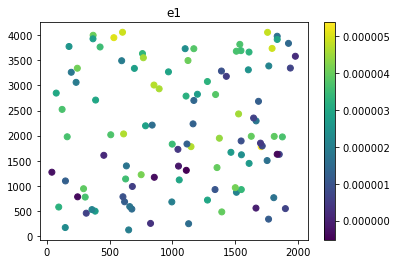

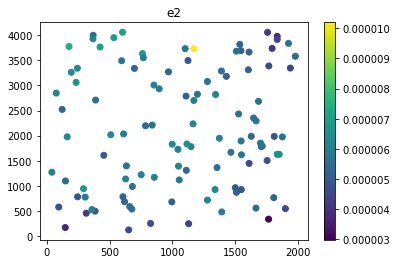

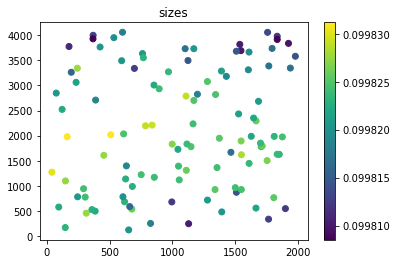

In [20]:
#plot size/shape for model at star locations
fwhm = 0.8
piff_e1 = []
piff_e2 = []
piff_sizes = []
for i in range(len(x_cat)):
    temp = psf.draw(x_cat[i], y_cat[i])
    galsim.fits.write(temp, 'temp.fits', piffdir)
    tempimg = galsim.fits.read('temp.fits', piffdir)
#     dx, dy, g1, g2, T, flux, flag = f.hsm(temp, None, logger)
    dx, dy, g1, g2, T, flux, flag = ngmix_fit(tempimg, None, fwhm, x_cat[i], y_cat[i], logger)
    piff_e1.append(g1)
    piff_e2.append(g2)
    piff_sizes.append(T)
        
plt.title('e1')
plt.scatter(x_cat, y_cat, c=piff_e1)
plt.colorbar()
plt.figure()
plt.title('e2')
plt.scatter(x_cat, y_cat, c=piff_e2)
plt.colorbar()
plt.figure()
plt.title('sizes')
plt.scatter(x_cat, y_cat, c=piff_sizes)
plt.colorbar()

0.23083121537055093 0.26310282854404665
0.0693335537308
made jac
0.23083121537055093 0.26310282854404665
0.0693335537308
made jac
0.23083121537055093 0.26310282854404665
0.0693335537308
made jac
0.23083121537055093 0.26310282854404665
0.0693335537308
made jac
0.23083121537055093 0.26310282854404665
0.0693335537308
made jac
0.23083121537055093 0.26310282854404665
0.0693335537308
made jac
0.23083121537055093 0.26310282854404665
0.0693335537308
made jac
0.23083121537055093 0.26310282854404665
0.0693335537308
made jac
0.23083121537055093 0.26310282854404665
0.0693335537308
made jac
0.23083121537055093 0.26310282854404665
0.0693335537308
made jac
0.23083121537055093 0.26310282854404665
0.0693335537308
made jac
0.23083121537055093 0.26310282854404665
0.0693335537308
made jac
0.23083121537055093 0.26310282854404665
0.0693335537308
made jac
0.23083121537055093 0.26310282854404665
0.0693335537308
made jac
0.23083121537055093 0.26310282854404665
0.0693335537308
made jac
0.23083121537055093 0.263

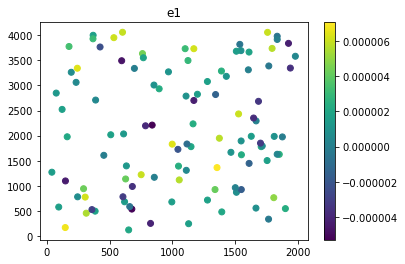

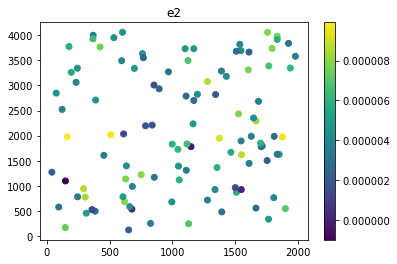

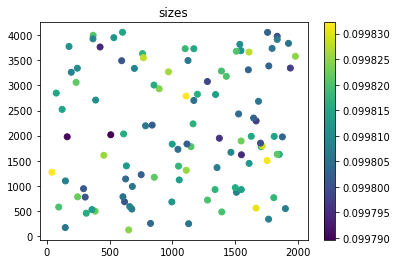

In [21]:
#make actual star measurements
full_image = galsim.fits.read(indir+image, hdu=1)
stamp_size = 48
fwhm = 0.8

star_e1 = []
star_e2 = []
star_sizes = []
for i in range(len(x_cat)):
    x = x_cat[i]
    y = y_cat[i]
    b = galsim.BoundsI(int(x)-stamp_size/2, int(x)+stamp_size/2, int(y)-stamp_size/2, int(y)+stamp_size/2)
    b = b & full_image.bounds
    im = full_image[b]
#     dx, dy, g1, g2, T, flux, flag = f.hsm(im, None, logger)
    dx, dy, g1, g2, T, flux, flag = ngmix_fit(tempimg, None, fwhm, x_cat[i], y_cat[i], logger)
    star_e1.append(g1)
    star_e2.append(g2)
    star_sizes.append(T)
        
plt.title('e1')
plt.scatter(x_cat, y_cat, c=star_e1)
plt.colorbar()
plt.figure()
plt.title('e2')
plt.scatter(x_cat, y_cat, c=star_e2)
plt.colorbar()
plt.figure()
plt.title('sizes')
plt.scatter(x_cat, y_cat, c=star_sizes)
plt.colorbar()

In [22]:
e1_residuals = (np.array(piff_e1)-np.array(star_e1))
e2_residuals = (np.array(piff_e2)-np.array(star_e2))
T_residuals = (np.array(piff_sizes)-np.array(star_sizes))
# print(np.mean(e1_residuals))
# print(np.mean(e2_residuals))
# print(np.mean(T_residuals))
# print(T_residuals)

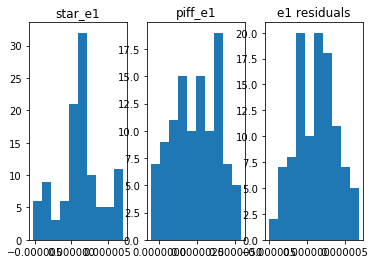

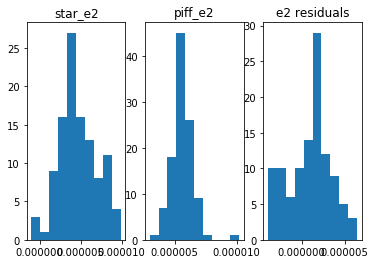

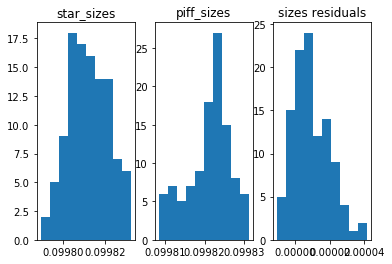

In [23]:
#using ngmix
#using hsm
fig, axs = plt.subplots(1, 3)
axs[0].set_title("star_e1")
axs[0].hist(star_e1)
axs[1].set_title("piff_e1")
axs[1].hist(piff_e1)
axs[2].set_title("e1 residuals")
axs[2].hist(e1_residuals)

fig2, axs2 = plt.subplots(1, 3)
axs2[0].set_title("star_e2")
axs2[0].hist(star_e2)
axs2[1].set_title("piff_e2")
axs2[1].hist(piff_e2)
axs2[2].set_title("e2 residuals")
axs2[2].hist(e2_residuals)

fig3, axs3 = plt.subplots(1, 3)
axs3[0].set_title("star_sizes")
axs3[0].hist(star_sizes)
axs3[1].set_title("piff_sizes")
axs3[1].hist(piff_sizes)
axs3[2].set_title("sizes residuals")
axs3[2].hist(T_residuals)
plt.show()

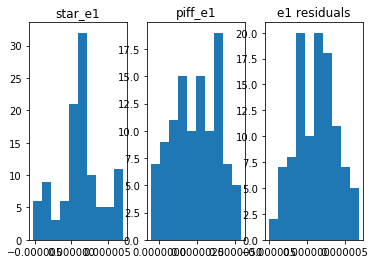

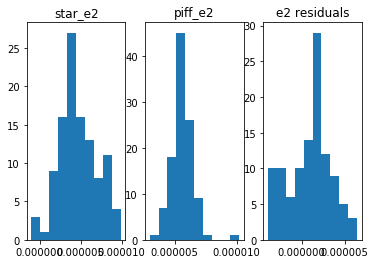

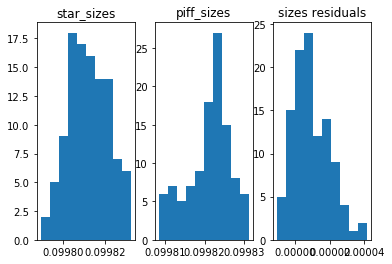

In [24]:
#using hsm
fig, axs = plt.subplots(1, 3)
axs[0].set_title("star_e1")
axs[0].hist(star_e1)
axs[1].set_title("piff_e1")
axs[1].hist(piff_e1)
axs[2].set_title("e1 residuals")
axs[2].hist(e1_residuals)

fig2, axs2 = plt.subplots(1, 3)
axs2[0].set_title("star_e2")
axs2[0].hist(star_e2)
axs2[1].set_title("piff_e2")
axs2[1].hist(piff_e2)
axs2[2].set_title("e2 residuals")
axs2[2].hist(e2_residuals)

fig3, axs3 = plt.subplots(1, 3)
axs3[0].set_title("star_sizes")
axs3[0].hist(star_sizes)
axs3[1].set_title("piff_sizes")
axs3[1].hist(piff_sizes)
axs3[2].set_title("sizes residuals")
axs3[2].hist(T_residuals)
plt.show()

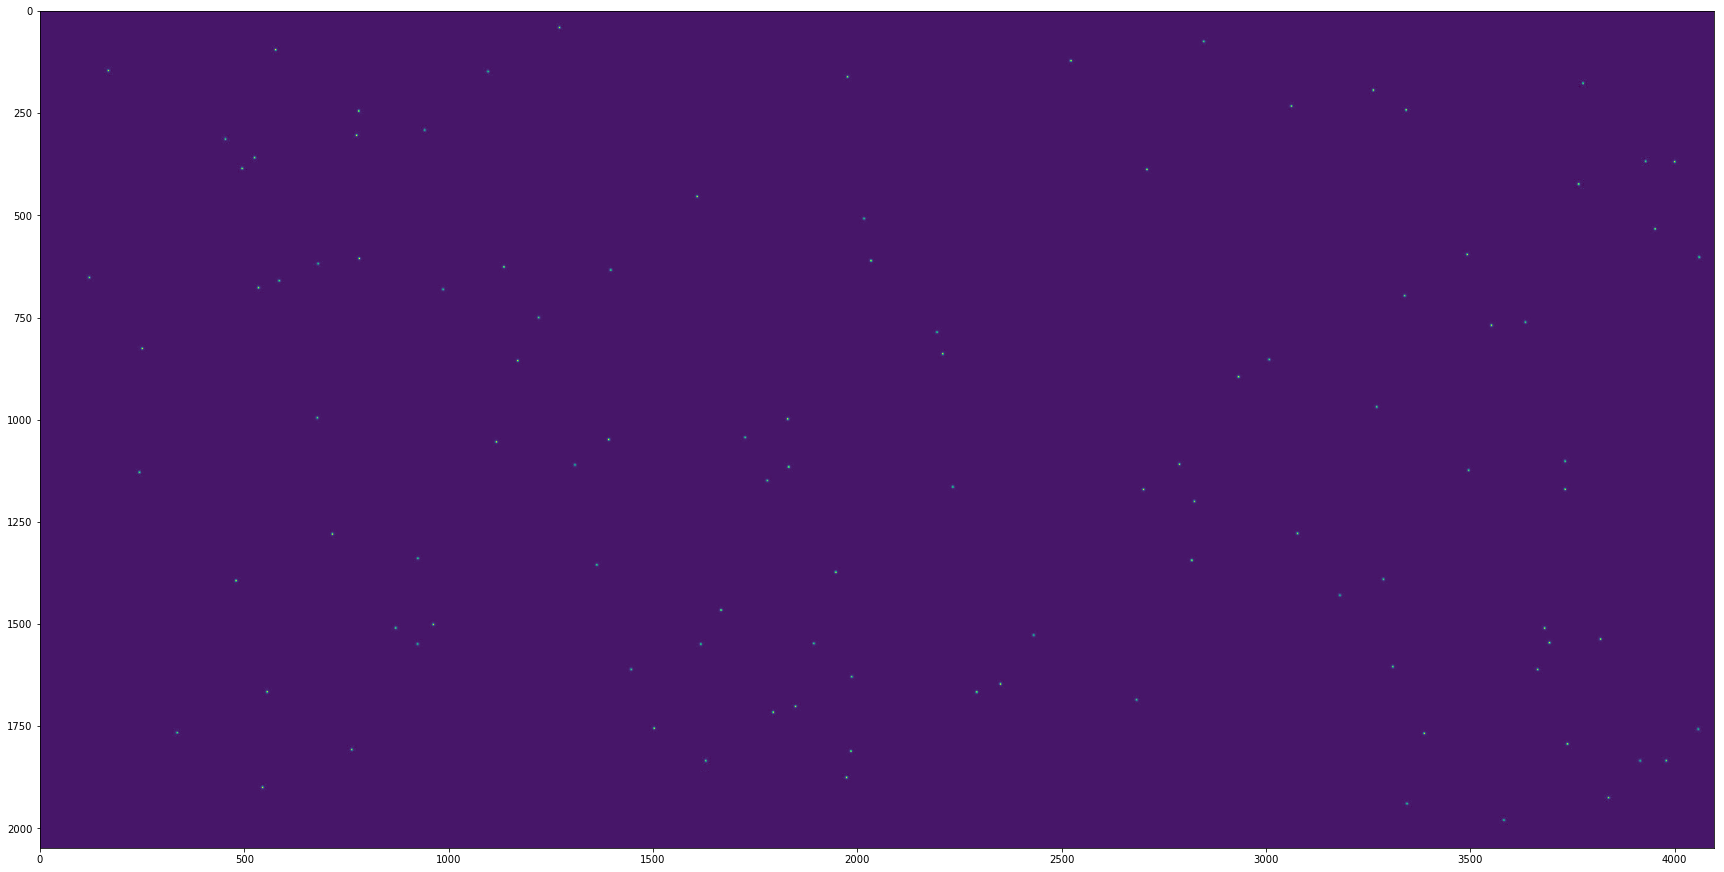

In [26]:
#plots psf on star positions
width = 24
plt.figure(figsize=(30,40))
Image = np.zeros((2048, 4096))
for i in range(len(x_cat)):
    temp = psf.draw(x_cat[i], y_cat[i])
    temp.write(piffdir+'DECam_'+str(ID)+'_'+str(chip)+'_tempimg.fits')
    temp = pf.open(piffdir+'DECam_'+str(ID)+'_'+str(chip)+'_tempimg.fits')
    x = int(x_cat[i])
    y = int(y_cat[i])
    #cuts out border stars completey
    if (x-width >= 0 and y-width >= 0 and x+width <= 2048 and y+width <= 4096):
        Image[x-width:x+width,y-width:y+width] = temp[0].data
# Image[500-width:500+width,500-width:500+width] = test[0].data
plt.imshow(Image)

/Users/rebeccachen/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  
/Users/rebeccachen/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  


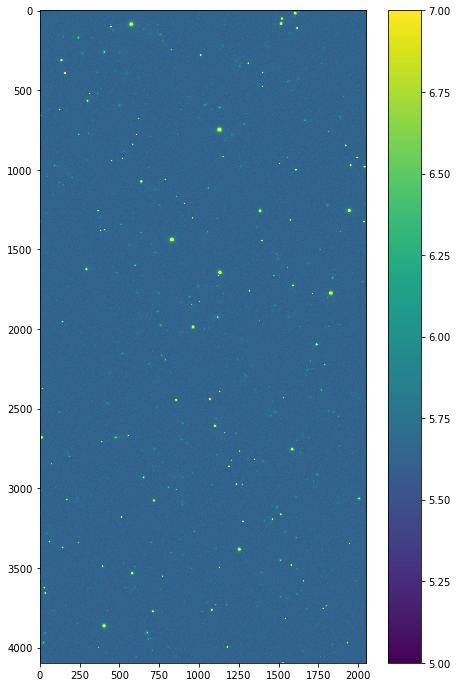

In [27]:
plt.figure(figsize=(8,12))
plt.imshow(np.log(pf.open(indir+image)[1].data))
plt.colorbar()
plt.clim(5,7)